# Organoid Image Exploration

In this notebook, we'll begin exploring how we can aggregate the brain organoid imaging data provided by the UCSC Genomics Institute.  

The `BASE_PATH` variable denotes the base folder for where the images are downloaded. This will eventually be run on the PRP, so the first few cells will probably only be relevant locally.

In [7]:
import numpy as np
import os 
from datetime import datetime

BASE_PATH = '/Users/julian/images'

times = next(os.walk(BASE_PATH))[1]
times = sorted(times)

subcameras = []
time_cam_dict = {}

for time in times:
    joinedpath = os.path.join(BASE_PATH, time)
    timecam = next(os.walk(joinedpath))[1]
    time_cam_dict[time] = timecam

# time_cam_dict

The code above generates the dictionary `time_cam_dict`, which is a list of key-value pairs in which each key is a time, and each value is the list of cameras that took pictures during that time. It is *not* safe to assume that all the cameras are the same throughout each time, as there are certain ones missing. The `BASE_PATH` denotes the base image path containing top level subfolders which are each time increment.

We now demonstrate how to create a composite image from each camera, which takes 10 pictures at each time increment.

In [8]:
time_cam_dict['2020-07-07T02:53:10'].index('cameraC33')

10

In [9]:
ex_folder = time_cam_dict['2020-07-07T02:53:10'][10] 
fold_path = os.path.join(BASE_PATH, '2020-07-07T02:53:10', ex_folder)

Now that we've selected a sample folder, let's generate a composite image from the original 10 images, then view it. 

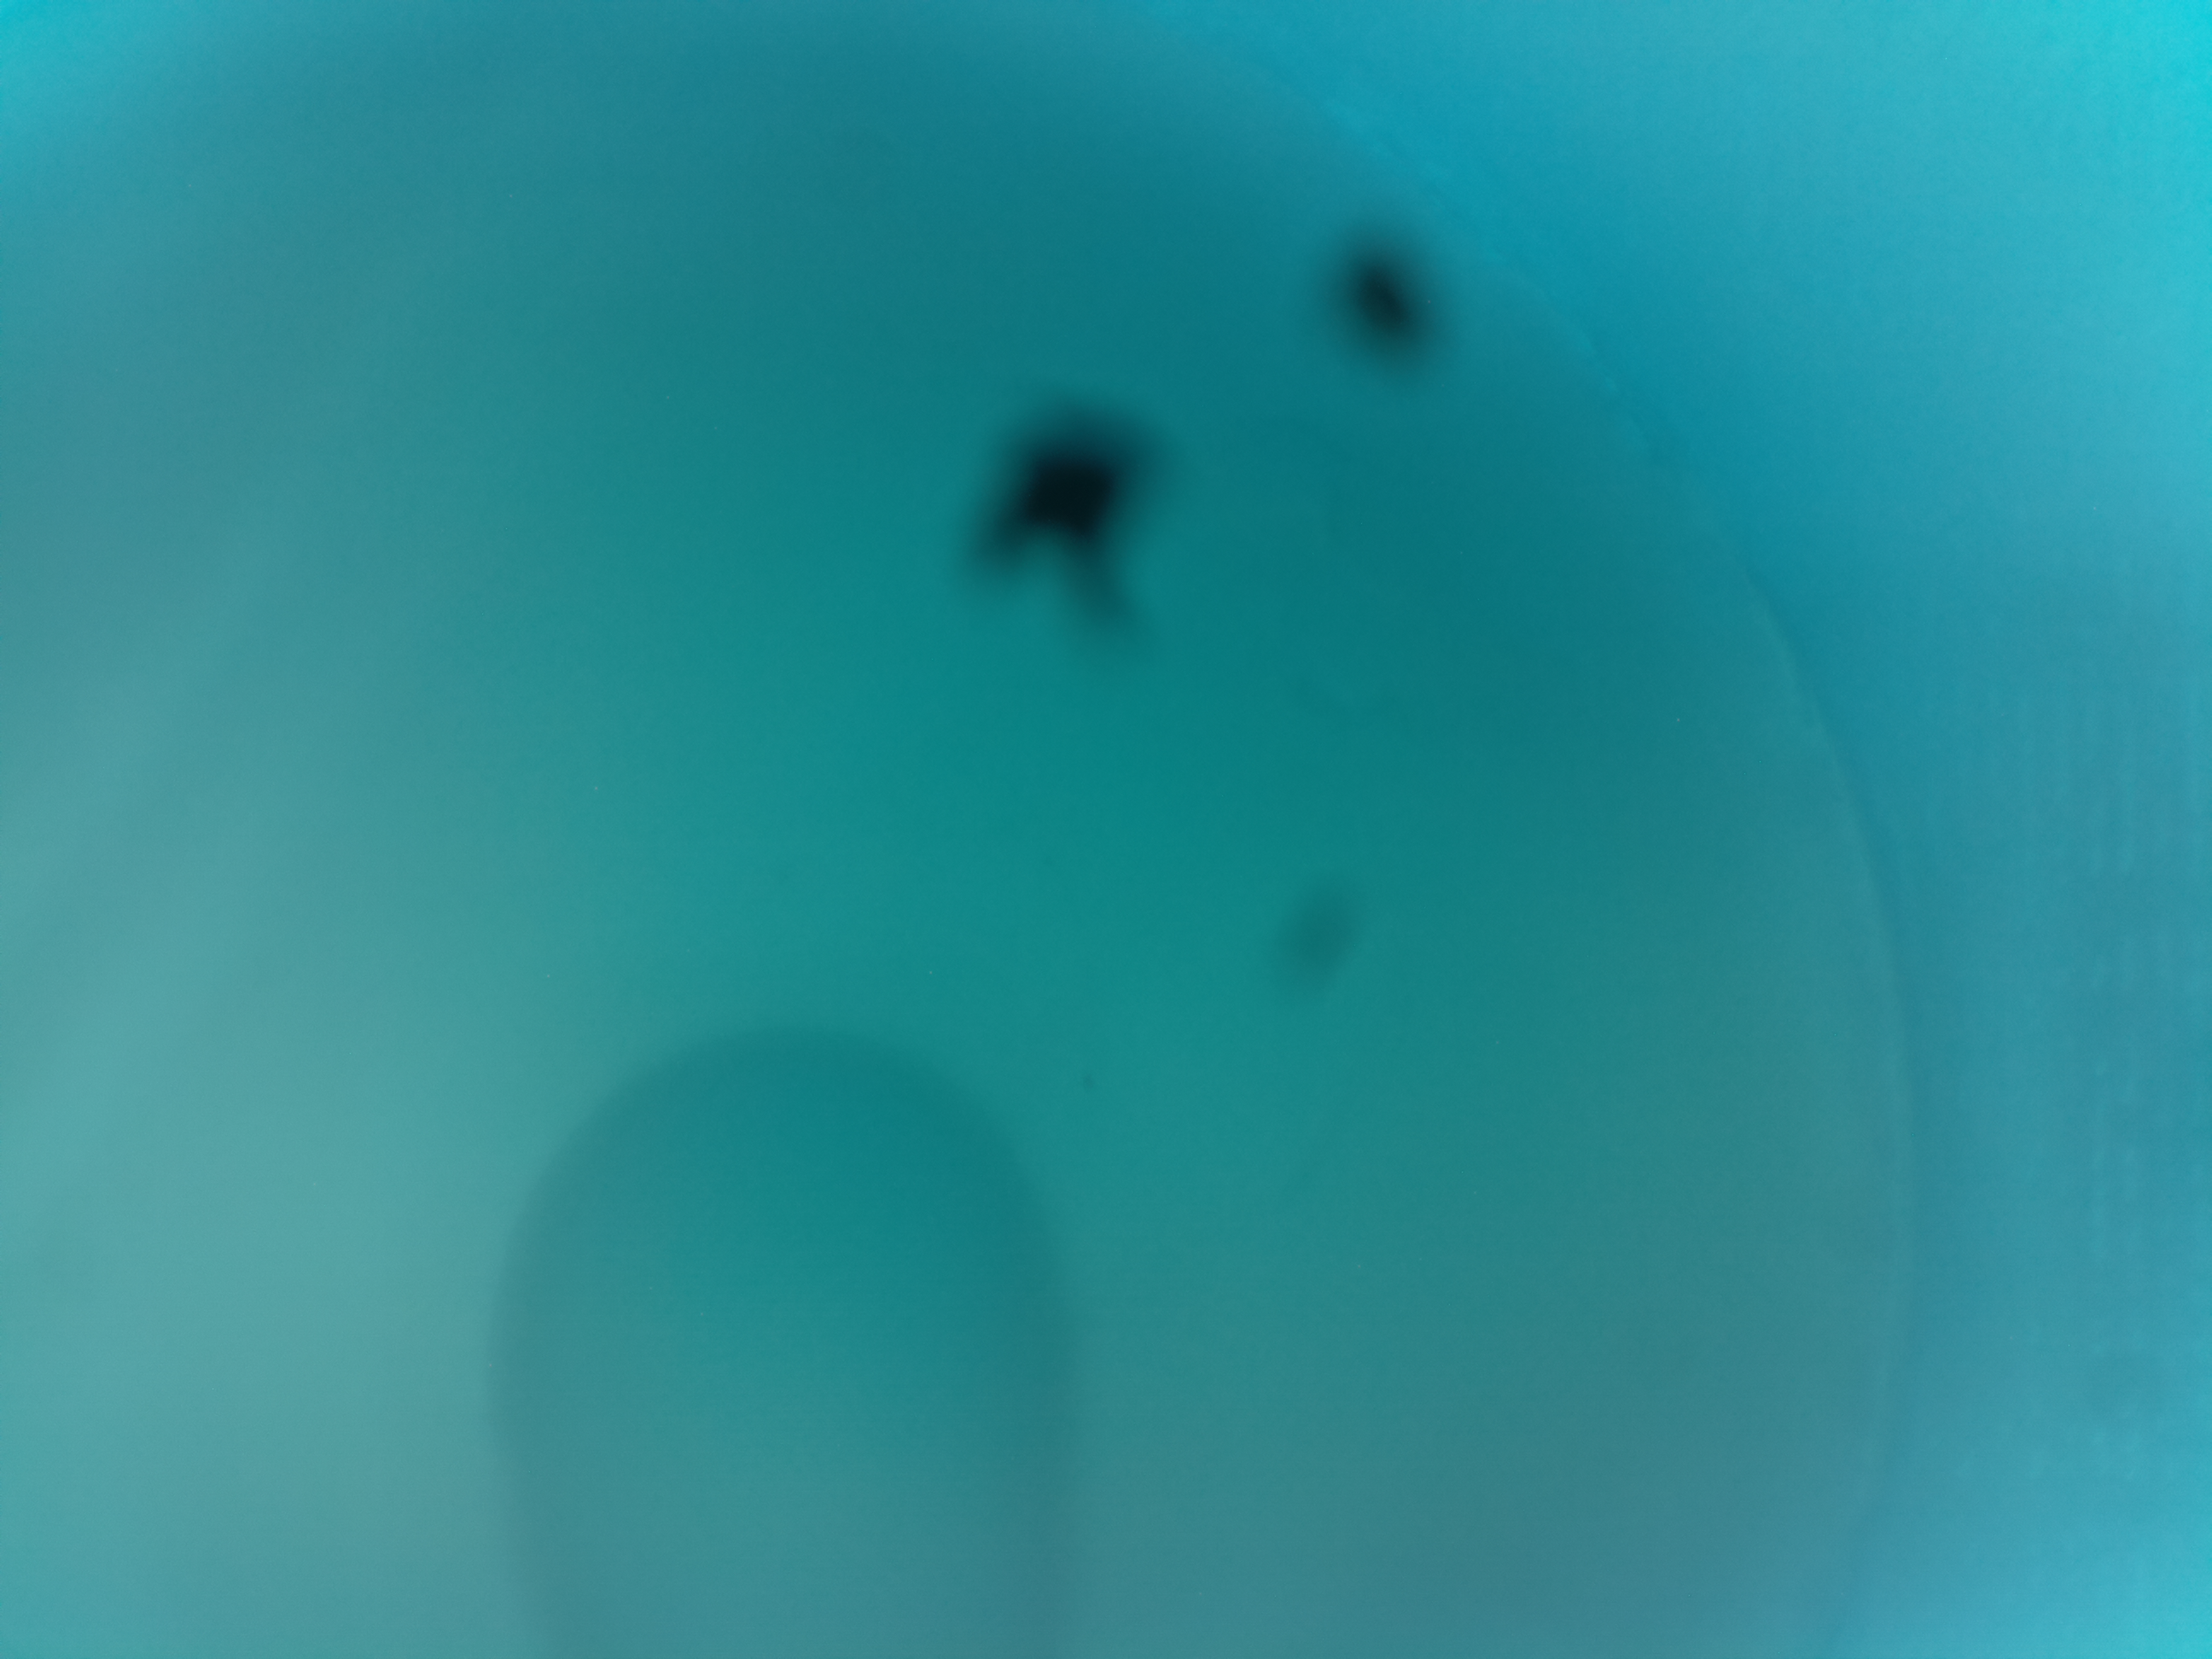

In [10]:
from more_itertools import pairwise
from PIL import Image, ImageDraw, ImageFilter

composite = Image.open(os.path.join(fold_path, '1.jpg'))
mask = Image.new("L", composite.size, 128)

for image in os.listdir(fold_path):
    img = Image.open(os.path.join(fold_path, image))
    composite = Image.composite(composite, img, mask)
    
display(composite)

Now let's define a method to do this for a given folder, and generate 1 composite image for each camera at each time interval.

In [11]:
def generate_organoid_composite(path):
    '''Generates a composite image from each image in the given path'''
    files = os.listdir(path)
    composite = Image.open(os.path.join(path, files[0]))
    mask = Image.new("L", composite.size, 128)

    for image in files:
        img = Image.open(os.path.join(path, image))
#         print(os.path.join(path, image))
        composite = Image.composite(composite, img, mask)
    
    composite.save(os.path.join(path, 'composite.jpg'))

Now, let's run it on each camera in each subfolder

In [6]:
# for time in time_cam_dict:
#     dir_list = next(os.walk(os.path.join(BASE_PATH, time)))[1]
#     print(time)
#     for camera in dir_list:
#         generate_organoid_composite(os.path.join(BASE_PATH, time, camera))

## Detecting Organoid Shapes and Sizes

We want to detect the size of the organoids in the images. To do this, we'll use OpenCV's circle detection, and compare across all time increments. 

We'll first demonstrate on a random image, and then generalize our method to be run on the PRP against all organoid images. 

In [12]:
import sys
import cv2 as cv
import numpy as np

src = cv.imread(cv.samples.findFile('/Users/julian/images/2020-07-07T10:54:00/cameraC25/composite.jpg'), cv.IMREAD_COLOR)

# Check if file loaded correctly
if src is None:
    print ('Error opening image!')
    print ('Usage: hough_circle.py [image_name -- default ' + default_file + '] \n')

Now, we convert our image to greyscale 

In [13]:
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

Apply a median blur to reduce noise and false circle detection

In [14]:
gray = cv.medianBlur(gray, 5)

In [15]:
rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, rows / 8,
                           param1=100, param2=30,)

In [16]:
if circles is not None:
    print('HELLO')
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(src, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(src, center, radius, (255, 0, 255), 3)

In [ ]:
cv.imshow("detected circles", src)
cv.waitKey(0)